# Baseline Models and Forecast Methods

Recall from our regression lessons that an important step in predictive modeling is establishing a baseline for comparison purposes. Let's introduce a few options for time series forecasting.

## What we will accomplish

In this notebook we will:
- Introduce six baseline models:
    - For data without trend or seasonality:
        - A gaussian white noise model which gives us the "average" forecast
        - A gaussian random walk forecast which gives us the "naive" forecast
    - For data with trend but not seasonality:
        - A linear trend model
        - A random walk with drift model
    - Forecasts for data with seasonality but not trend:
        - A deterministic seasonality with gaussian white noise model, which gives the "seasonal average" forecast
        - A seasonal random walk model

- And discuss error measurement for forecasting.

### Notation

Throughout this notebook we will assume that $y_t$ is a time series, that the training set has $n$ observations and that we are interested in predicting observations at times $t > n$.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

#### Two data sets

We will illustrate these forecasts on two data sets. The first is Google's parent company's closing stock price for each trading day from August 19, 2004 to March 25, 2022. This data set comes from <a href="https://finance.yahoo.com/">Yahoo! Finance</a>. The second data set are the weekly seasonal influenza case counts for the United States of America from 1931 to 1950 provided by <a href="https://www.tycho.pitt.edu/">Project Tycho</a>.

## Data without trend or seasonality

The first two forecasts are reasonable baselines for data that do not exhibit a trend or seasonality.

We will demonstrate their implementation with some Google stock data.

#### Predicting Google stock prices changes

The data we load below gives the Google parent company stock closing price on every trading day from August 19, 2004 to March 25, 2022.

In [89]:
## Load the data
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

In [90]:
## First five entries
goog.head()

,date,closing_price
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239197
4,2004-08-25,52.802086


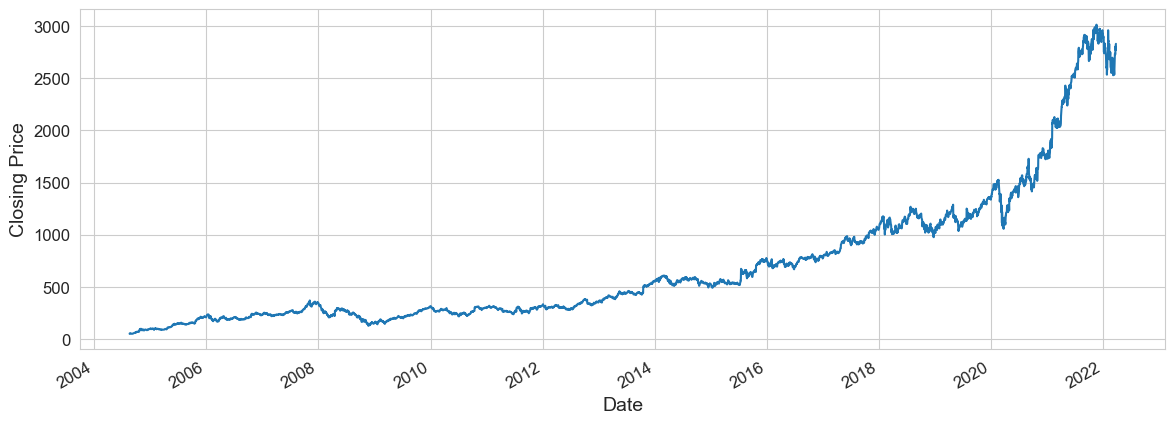

In [91]:
plt.figure(figsize=(14,5))

plt.plot(goog.date, goog.closing_price)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gcf().autofmt_xdate()


plt.show()

This data has a **clear trend**, so selecting a white or random walk forecast is **not appropriate**.

However, if we first **difference** the data, to look at the daily **change** we obtain data with no apparent trend.

In [92]:
goog['change'] = goog['closing_price'].diff()
goog.loc[0,'change'] = 0

In [93]:
goog[['change']]

,change
0,0.000000
1,3.970115
2,0.542965
3,-2.256538
4,0.562889
...,...
4427,-6.459961
4428,75.979981
4429,-35.479981
4430,56.169922


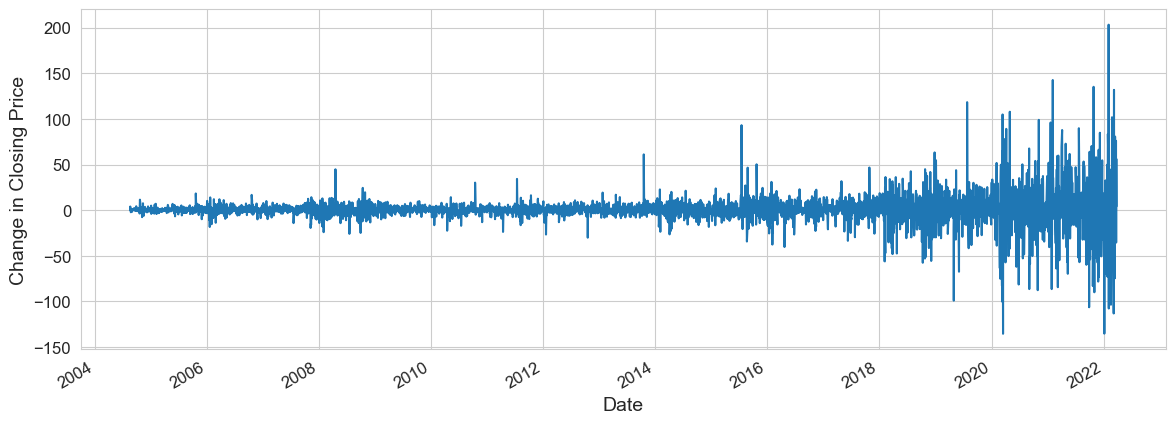

In [94]:
plt.figure(figsize=(14,5))

plt.plot(goog.date, goog.change)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Change in Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gcf().autofmt_xdate()

plt.show()

We will build baseline models that forecast the change in closing price for the next two weeks.

For simplicity, we will <i>not</i> be performing cross-validation, we will just compare both models to the last 14 trading days in the data set.

In [95]:
goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

### A Gaussian white noise model.

One baseline model is the <i>Gaussian white noise model</i>.  

We hypothesize a data generating process of the form:

$$
f(t) = \mu + \epsilon_t
$$

with $\mu$ as some constant and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$.  In this context we can call our error terms "Gaussian white noise".

The MLE fitted model will have $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$, and $\hat{\sigma}^2 = \displaystyle \frac{1}{n} \sum_{i=1}^n (y - \hat{\mu})^2$.

### Average Forecast

This leads to the **average forecast**:  To predict the value of $y_t$ for $t>n$ we just report $\hat{\mu} = \displaystyle \frac{1}{n}\sum_{i=1}^n y_i$.

<i>Note: for this estimate to be "good" the assumption that the $y_t$ are independent and identically distributed</i>.  We can see that this is **not true** for the google data, since the variance has clearly been increasing over time.

In [96]:
## Making the average "prediction"
goog_avg = goog_train.change.mean()*np.ones(len(goog_test))

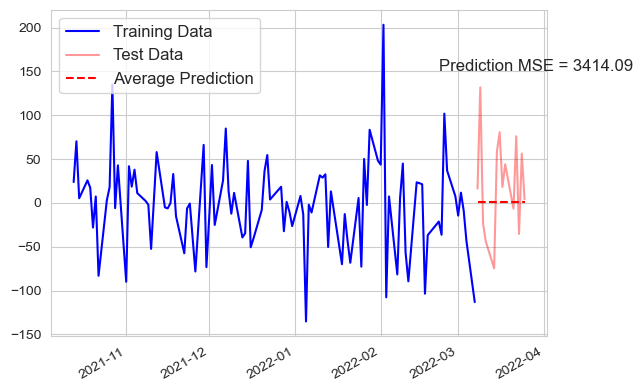

In [97]:
## Plotting the average prediction with the actual data
plt.plot(goog_train.date[-100:],
            goog_train.change[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.change,
            'r-',
            label="Test Data",
            alpha = 0.4
            )

plt.plot(goog_test.date,
            goog_avg,
            'r--',
            label="Average Prediction")

plt.text(goog_train.date.values[-10],
         goog_avg[0]+150,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.change.values,
                                                                  goog_avg), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)
plt.gcf().autofmt_xdate()


plt.show()

In [98]:
sigma = np.sqrt(mean_squared_error(goog_train.change,goog_train.change.mean()*np.ones(len(goog_train.index))))

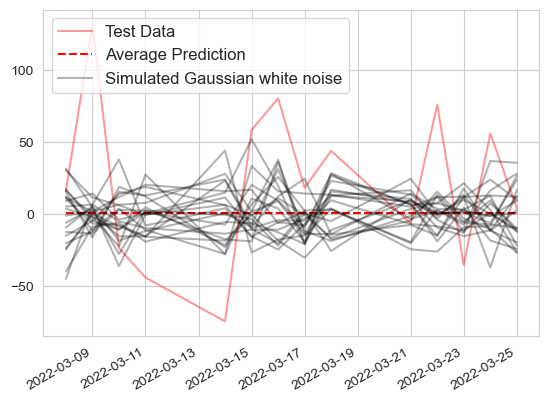

In [99]:
plt.plot(goog_test.date,
            goog_test.change,
            'r-',
            label="Test Data",
            alpha = 0.4
            )

plt.plot(goog_test.date,
            goog_avg,
            'r--',
            label="Average Prediction")

for i in range(20):
    plt.plot(goog_test.date,
            goog_avg + np.random.normal(0, sigma, size = (14,)),
            'k',
            alpha = 0.3
            )

plt.plot(goog_test.date,
            goog_avg + np.random.normal(0, sigma, size = (14,)),
            'k',
            alpha = 0.3,
            label = 'Simulated Gaussian white noise'
            )

plt.legend(fontsize=12, loc=2)
plt.gcf().autofmt_xdate()


plt.show()

In [100]:
goog_avg.shape

(14,)

### A Gaussian Random Walk Model

Another baseline you may consider is a **Gaussian Random Walk** model, which is the process

$$
y_t = y_{t-1} + \epsilon_t
$$

where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$.

We fit this model by computing $\hat{\sigma}^2 = \frac{1}{n} \displaystyle \sum_1^n (y_t - y_{t-1})^2$.

### Naive Forecast
This leads to the **naive forecast** which is just to set $y_t = y_n$ for $t>n$.  In other words, we just predict the last observed value!



In [151]:
## Making the naive "prediction"
goog_naive = goog_train.change.values[-1]*np.ones(len(goog_test))
sigma = np.sqrt(np.power((goog_train.change.diff()[:-1]),2).sum()/len(goog_train))

In [102]:
goog_naive

array([-113.149902, -113.149902, -113.149902, -113.149902, -113.149902,
       -113.149902, -113.149902, -113.149902, -113.149902, -113.149902,
       -113.149902, -113.149902, -113.149902, -113.149902])

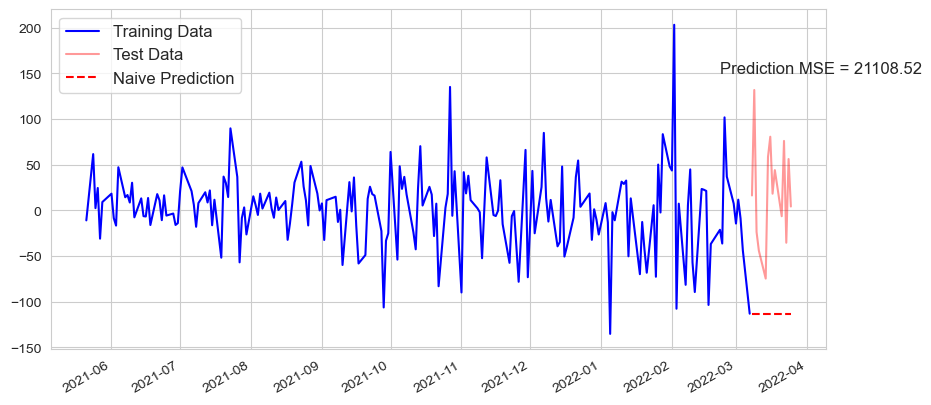

In [103]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-200:],
            goog_train.change[-200:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.change,
            'r-',
            alpha = 0.4,
            label="Test Data")

plt.plot(goog_test.date,
            goog_naive,
            'r--',
            label="Naive Prediction")

plt.text(goog_train.date.values[-10],
         150,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.change.values,
                                                                  goog_naive), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)
plt.gcf().autofmt_xdate()


plt.show()

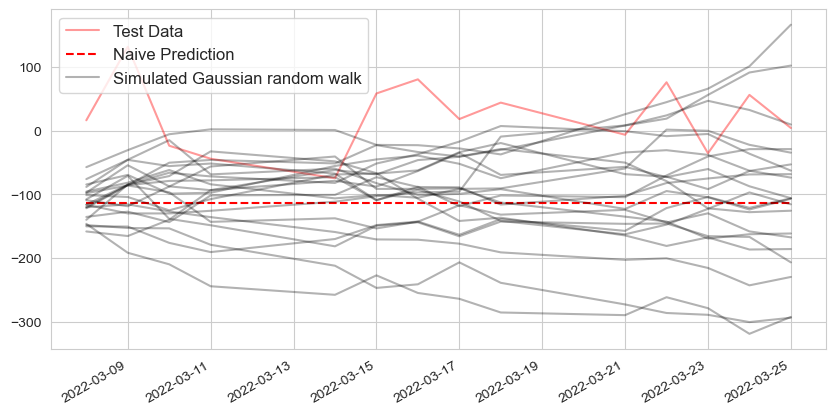

In [104]:
plt.figure(figsize=(10,5))

plt.plot(goog_test.date,
            goog_test.change,
            'r-',
            alpha = 0.4,
            label="Test Data")

plt.plot(goog_test.date,
            goog_naive,
            'r--',
            label="Naive Prediction")

for i in range(20):
    plt.plot(goog_test.date,
            goog_naive + np.random.normal(0, sigma, size = (14,)).cumsum(),
            'k',
            alpha = 0.3
            )

plt.plot(goog_test.date,
            goog_naive + np.random.normal(0, sigma, size = (14,)).cumsum(),
            'k',
            alpha = 0.3,
            label = 'Simulated Gaussian random walk'
            )



plt.legend(fontsize=12, loc=2)
plt.gcf().autofmt_xdate()


plt.show()

## Data with trend but no seasonality

These two forecasts can serve as decent baselines for data sets with a linear trend but no seasonality.

Again we will demonstrate with the Google data set.  Since the original data appears exponential, I will look at the price:

In [105]:
goog['log_price'] = np.log10(goog['closing_price'])
goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

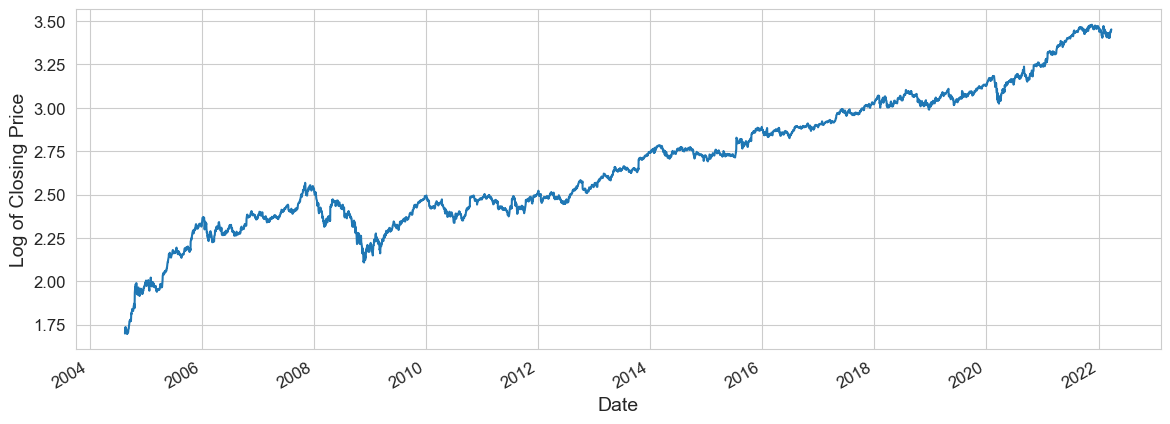

In [106]:
plt.figure(figsize=(14,5))

plt.plot(goog.date, goog.log_price)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gcf().autofmt_xdate()


plt.show()

### A linear trend model

A baseline linear trend model will assume that the time series is a linear function of time plus some random noise, i.e.:

$$
f(t) = \beta_0 + \beta_1 t + \epsilon_t
$$

where $\beta_0, \beta_1 \in \mathbb{R}$ and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.


#### Fitting the model

To estimate $\beta_0, \ \beta_1$ we can fit a linear regression model using the time point as the feature you are regressing on.

####  Linear trend forecast

Our forecase simply predicts $y_t = \beta_0 + \beta_1 t$ for $t>n$.

In [107]:
## import linear regression
from sklearn.linear_model import LinearRegression

In [108]:
## Make the model object
reg = LinearRegression()

## Fit the model
reg.fit(np.array(goog_train.index).reshape(-1,1),
        goog_train.log_price)

## Make the forecast
trend_pred = reg.predict(np.array(goog_test.index).reshape(-1,1))

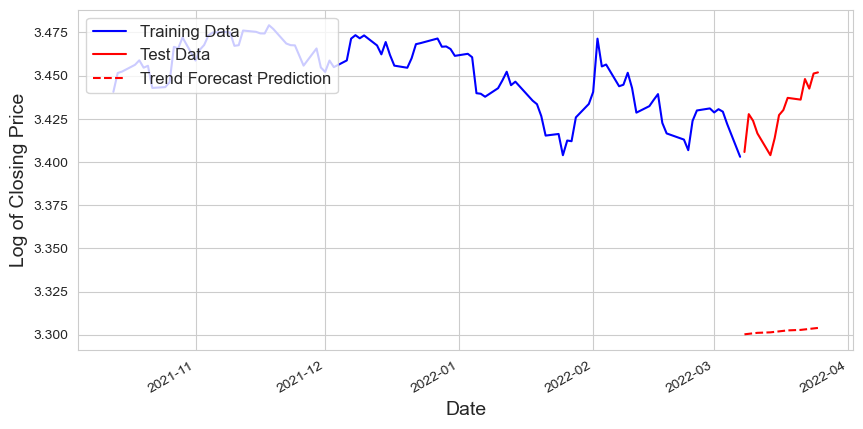

In [109]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-100:],
            goog_train.log_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            trend_pred,
            'r--',
            label="Trend Forecast Prediction")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Closing Price", fontsize=14)

plt.legend(fontsize=12, loc=2)

plt.gcf().autofmt_xdate()

plt.show()

Zoomed out it looks like this:

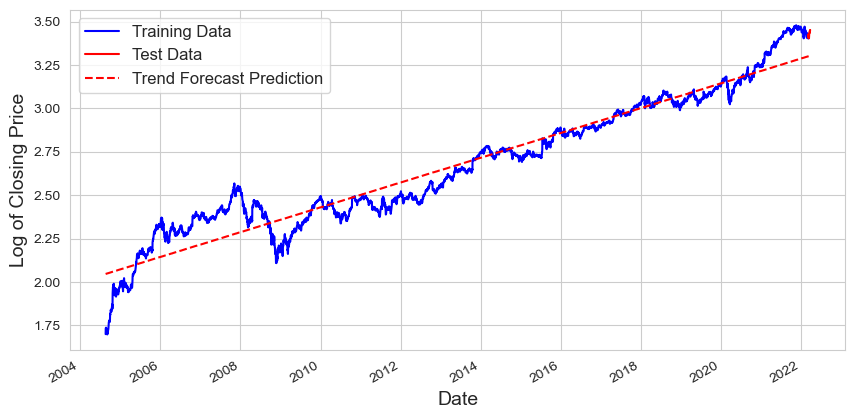

In [110]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date,
            goog_train.log_price,
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog.date,
            reg.predict(np.array(goog.index).reshape(-1,1)),
            'r--',
            label="Trend Forecast Prediction")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Closing Price", fontsize=14)

plt.legend(fontsize=12, loc=2)

plt.gcf().autofmt_xdate()


plt.show()

Something to notice here is that the residuals have long runs where they are either positive or negative.  This is not indicative of normally distributed residuals!  A big part of time series modeling, which makes it different from the regression analysis we have done so far, lies in accounting for the time dependence of the errors.

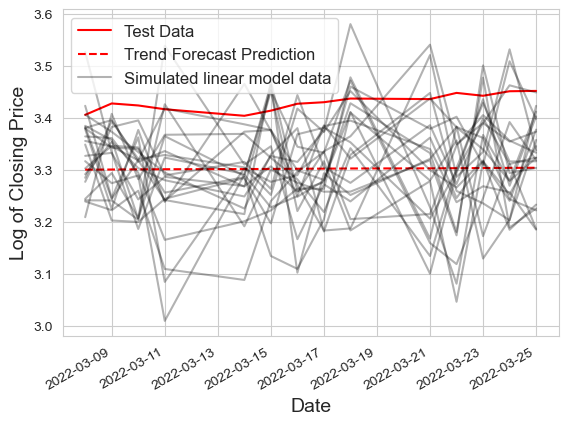

In [130]:
y_train = goog_train.log_price
y_train_pred = reg.predict(np.array(goog_train.index).reshape(-1,1))
residuals = y_train - y_train_pred

sigma = np.sqrt(((residuals)**2).sum()/len(residuals))

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            trend_pred,
            'r--',
            label="Trend Forecast Prediction")

for i in range(20):
    plt.plot(goog_test.date,
            trend_pred + np.random.normal(0, sigma, size = (14,)),
            'k',
            alpha = 0.3
            )

plt.plot(goog_test.date,
            trend_pred + np.random.normal(0, sigma, size = (14,)),
            'k',
            alpha = 0.3,
            label = 'Simulated linear model data'
            )

plt.xlabel("Date", fontsize=14)
plt.ylabel("Log of Closing Price", fontsize=14)



plt.legend(fontsize=12, loc=2)
plt.gcf().autofmt_xdate()


plt.show()

### A random walk with drift

The model is:

$$
y_0 = \beta_0 \ \ \text{ and } \ \ y_{t+1} = y_{t} + \beta_1 + \epsilon_t
$$


where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.

This is similar to the linear model, but the data generating process is different.  The MLE estimates of the parameters are

$$
\begin{align*}
\hat{\beta}_1 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1}) = \frac{1}{n} (y_n - y_0)\\
\hat{\beta}_0 &= y_0\\
\hat{\sigma}^2 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1} - \hat{\beta}_1)^2
\end{align*}
$$

### Drift forecast

This leads to a **drift forecast** where we predict $y_t = y_n + \beta_1 (t-n)$ for $t > n$.

In [126]:
beta_hat = (goog_train.log_price.values[-1] - goog_train.log_price.values[0])/len(goog_train)
drift_pred = goog_train.log_price.values[-1] + beta_hat*np.arange(1,len(goog_test) + 1)
sigma = np.sqrt(((goog_train.log_price.diff() - beta_hat)**2).sum()/len(goog_train))

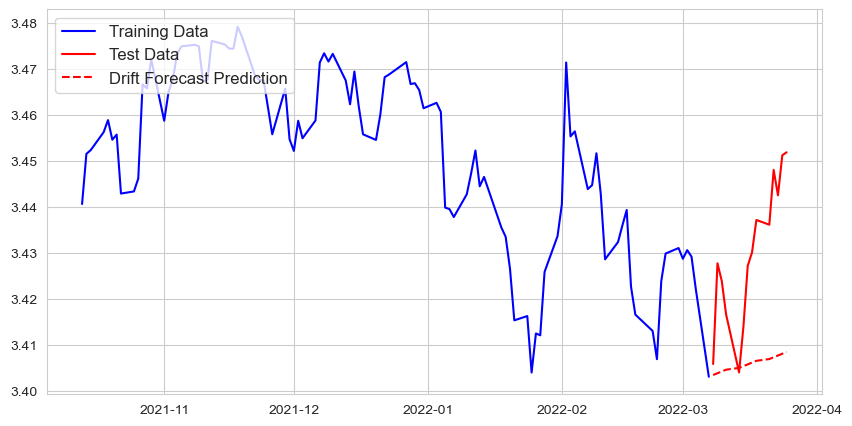

In [113]:
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-100:],
            goog_train.log_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            drift_pred,
            'r--',
            label="Drift Forecast Prediction")

plt.legend(fontsize=12, loc=2)

plt.show()

Zoomed out all the way:

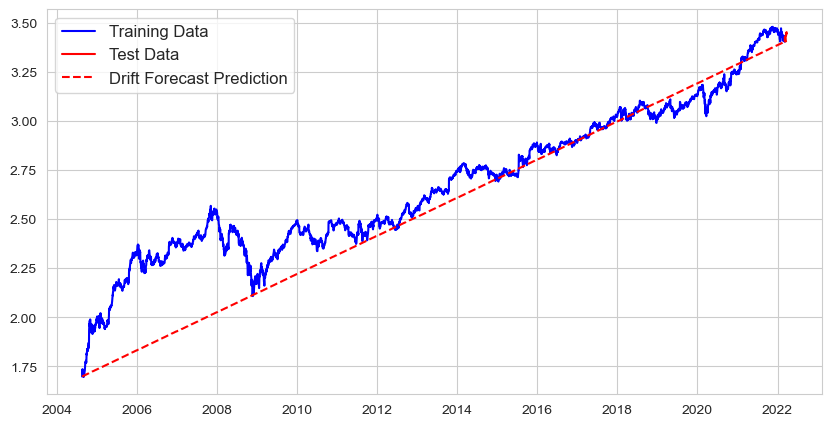

In [114]:
plt.figure(figsize=(10,5))

plt.plot(goog_train.date,
            goog_train.log_price,
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog.date,
            goog.log_price.values[0] + beta_hat*goog.index,
            'r--',
            label="Drift Forecast Prediction")

plt.legend(fontsize=12, loc=2)

plt.show()

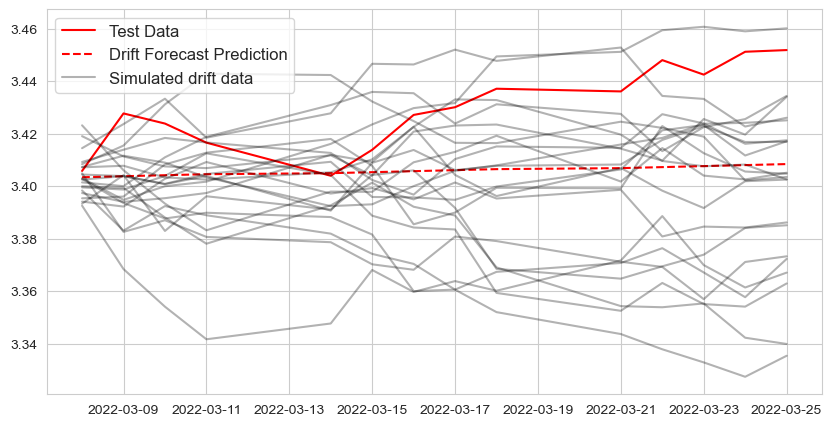

In [129]:
plt.figure(figsize=(10,5))

plt.plot(goog_test.date,
            goog_test.log_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            drift_pred,
            'r--',
            label="Drift Forecast Prediction")

for i in range(20):
    plt.plot(goog_test.date,
            drift_pred + np.random.normal(0, sigma, size = (14,)).cumsum(),
            'k',
            alpha = 0.3
            )

plt.plot(goog_test.date,
            drift_pred + np.random.normal(0, sigma, size = (14,)).cumsum(),
            'k',
            alpha = 0.3,
            label = 'Simulated drift data'
            )

plt.legend(fontsize=12, loc=2)

plt.show()

## Data with seasonality but no trend

#### Predicting US seasonal influenza incidence

Let's visualize the influenza data set now.

In [115]:
flu = pd.read_csv("../../data/us_flu_1928_1948.csv", parse_dates=['date'])

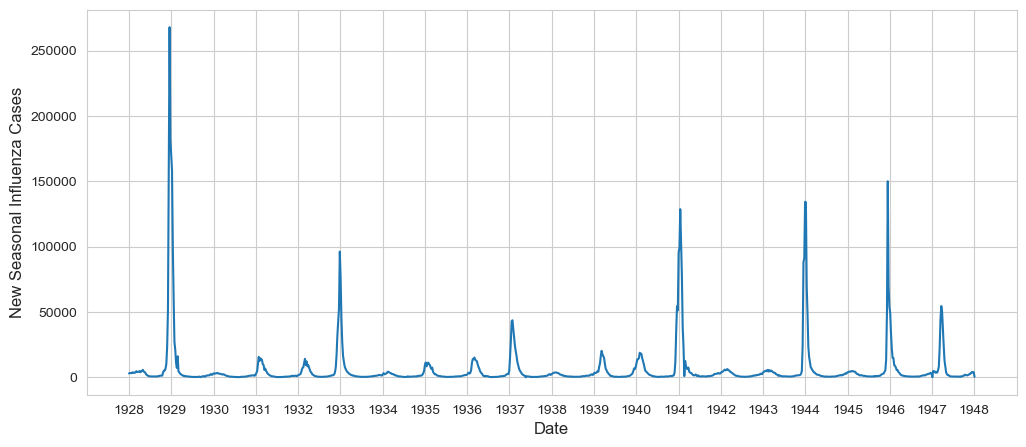

In [116]:
plt.figure(figsize=(12,5))

plt.plot(flu.date, flu.cases)

plt.xlabel("Date", fontsize=12)
plt.ylabel("New Seasonal Influenza Cases", fontsize=12)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=10)
plt.yticks(fontsize=10)

plt.show()

As we can see, this data exhibits a yearly pattern. New cases tend to increase at the end or beginning of each year and peak in the first quarter, declining afterward. This cycle occurs on a yearly basis. Time series that exhibit this kind of behavior are said to exhibit <i>seasonality</i>.

When we believe that our time series is seasonal we can use this knowledge to update our previous baseline models in an attempt to improve them.

We will use our two models to predict the new influenza cases in each week of 1947.

In [117]:
flu_train = flu.loc[flu.year!=1947].copy()
flu_test = flu.loc[flu.year==1947].copy()

## Seasonal average model

The seasonal average model assumes that each "season" is independently following a gaussian white noise model, where each season has a different mean but a common variance.

For season $j = 0,1,2,..., T-1$ let $D_{t,j}$ be a dummy variable with

$$
D_{t,j} = 
\begin{cases}
1 \textrm{ if } t \equiv j \mod T\\
0 \textrm{ else}
\end{cases}
$$

Then our statistical model is 

$$
\begin{align*}
y_t = &\epsilon_t + \sum_0^{T-1} \beta_j D_{t,j} \\
&\epsilon_t \sim \operatorname{NID}(0,\sigma^2)
\end{align*}
$$

The MLE fit model has 

- $\hat{\beta}_j$ is the mean value for the season, in other words the average of $y_{j}, y_{j+T}, y_{j+2T}, ...$
- $\hat{\sigma^2}$ is the variance of the residuals

## Seasonal average forecast

This leads to the **seasonal average forecast** where we simply report predicted value for a new $y_t$ with $t>n$ as the average of all observations in the same period $y_{t-T}, y_{t-2T}, y_{t-3T}, ...$

In [118]:
flu_train.head()

,date,year,week,cases
0,1928-01-01,1928,1,2938
1,1928-01-08,1928,2,3343
2,1928-01-15,1928,3,3208
3,1928-01-22,1928,4,3118
4,1928-01-29,1928,5,3743


In [140]:
## get the average model predictions
flu_avg = []

for week in range(1,53):
    flu_avg.append(flu_train.loc[flu_train.week==week].cases.mean())

flu_avg_dict = {(i+1):flu_avg[i] for i in range(52)}

In [142]:
flu_train['avg'] = flu_train['week'].map(flu_avg_dict)

In [148]:
sigma = np.sqrt((((flu_train['cases'] - flu_train['avg'])**2).sum())/len(flu_train))

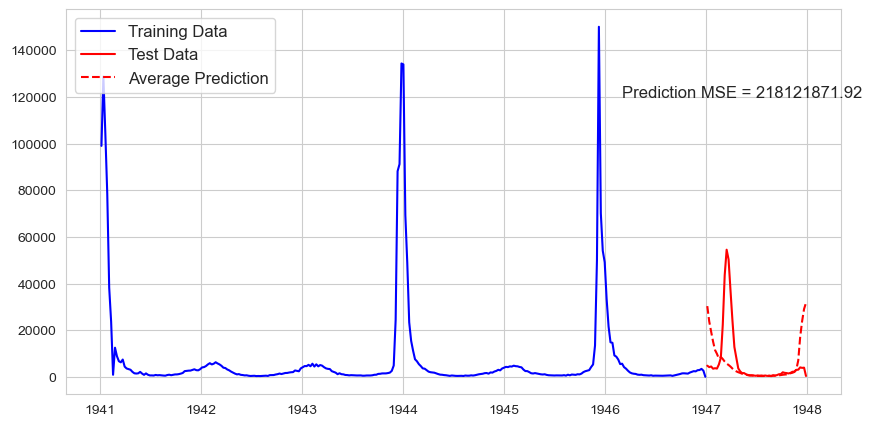

In [120]:
plt.figure(figsize=(10,5))

plt.plot(flu_train.date.values[-6*52:],
            flu_train.cases.values[-6*52:],
            'b-',
            label="Training Data")

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_avg,
            'r--',
            label="Average Prediction")

plt.text(datetime(1946, 3,1),
         120000,
         "Prediction MSE = " + str(np.round(mean_squared_error(flu_test.cases.values,
                                                                  flu_avg), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

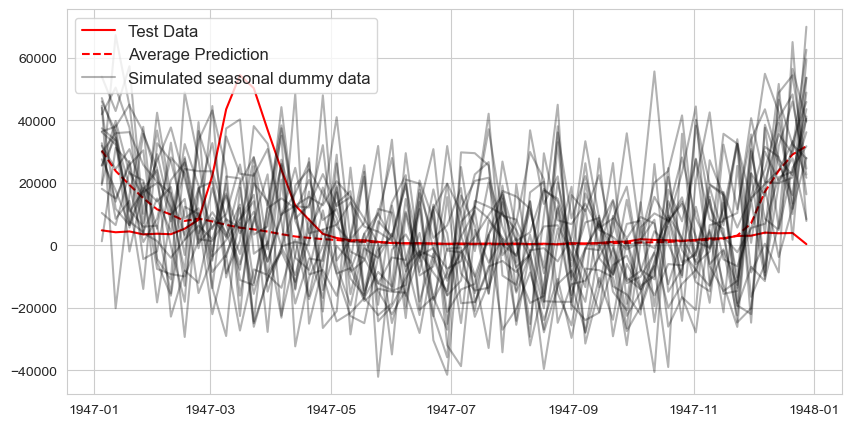

In [150]:
plt.figure(figsize=(10,5))

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_avg,
            'r--',
            label="Average Prediction")

for i in range(20):
    plt.plot(flu_test.date,
            flu_avg + np.random.normal(0, sigma, size = (52,)),
            'k',
            alpha = 0.3
            )

plt.plot(flu_test.date,
            flu_avg + np.random.normal(0, sigma, size = (52,)),
            'k',
            alpha = 0.3,
            label = 'Simulated seasonal dummy data'
            )

plt.legend(fontsize=12, loc=2)

plt.show()

## Seasonal random walk model

The seasonal random walk model is that each season is independently following a gaussian random walk with the same variance.

In other words we have

$$
\begin{align*}
y_t &= y_{t-T} + \epsilon_t\\
\epsilon_t &\sim \operatorname{NID}(0,\sigma^2)
\end{align*}
$$

We fit this model by computing $\hat{\sigma}^2 = \frac{1}{n - T} \displaystyle \sum_{T+1}^n (y_t - y_{t-T})^2$.

## Seasonal naive prediction

This leads to the seasonal naive prediction where we predict $y_t$ to be the corresponding value from the most recently observed season.

In [152]:
flu_naive = flu_train.loc[flu_train.year == 1946].cases.values

In [159]:
flu_train['lagged_diff'] = 0

In [160]:
for i in flu_train.index[52:]:
    flu_train.loc[i,'lagged_diff'] = flu_train.loc[i,'cases'] - flu_train.loc[i-52,'cases'] 

In [162]:
sigma = np.sqrt((flu_train['lagged_diff']**2).sum()/(len(flu_train) -52))

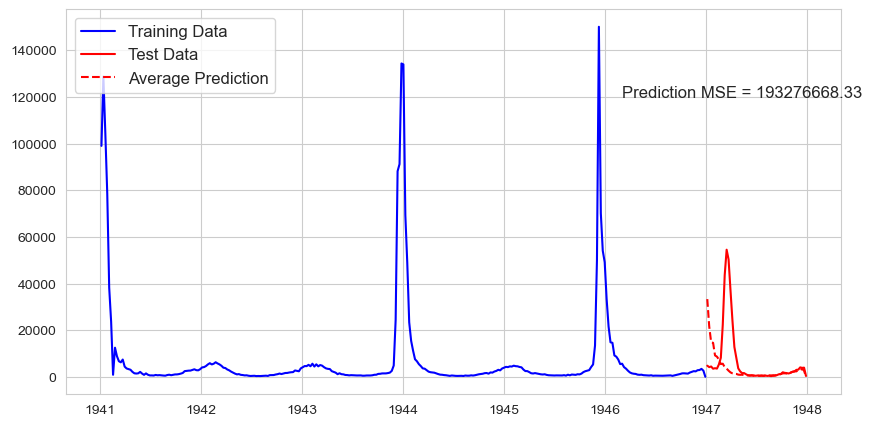

In [122]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(flu_train.date[-6*52:],
            flu_train.cases[-6*52:],
            'b-',
            label="Training Data")

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_naive,
            'r--',
            label="Average Prediction")

plt.text(datetime(1946, 3,1),
         120000,
         "Prediction MSE = " + str(np.round(mean_squared_error(flu_test.cases.values,
                                                                  flu_naive), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

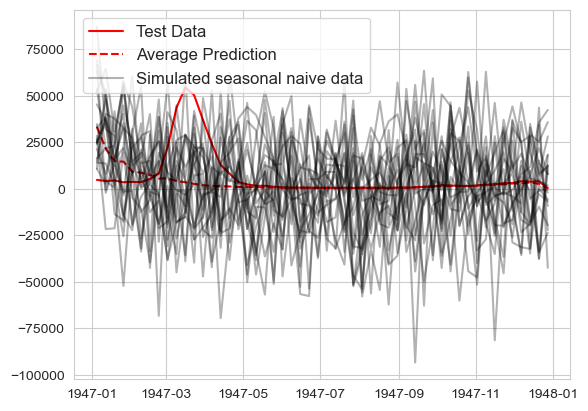

In [164]:

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_naive,
            'r--',
            label="Average Prediction")

for i in range(20):
    plt.plot(flu_test.date,
            flu_naive + np.random.normal(0, sigma, size = (52,)),
            'k',
            alpha = 0.3
            )

plt.plot(flu_test.date,
            flu_avg + np.random.normal(0, sigma, size = (52,)),
            'k',
            alpha = 0.3,
            label = 'Simulated seasonal naive data'
            )

plt.legend(fontsize=12, loc=2)

plt.show()

Again we can see that neither of these forecasts are particularly good. In this case the reason is twofold. First the height of the peak of flu season is not consistent. Sometimes you will have mild seasons and other times you will have harsh seasons. Peak occurrence is also inconsistent. Some seasons the peak occurs before the new year, while it occurs after the new year in others.

## Wrapping up

You now have six baselines to choose from depending on your data. While we did not cover baseline options for time series that exhibit both a trend and seasonality, there are extensions of the white noise and random walk models that can be used to produce forecasts for such data. This extension is left to the corresponding `Practice Problems` notebook.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)